In [1]:
# Import Required Dependency
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb
from scipy import stats
from sklearn.feature_selection import SelectFromModel

In [2]:
# Initialize Datasets path: Training, Test, SampleSubmission
trainDataFile = '/kaggle/input/wild-blueberryyield-regression/train.csv'
testDataFile = '/kaggle/input/wild-blueberryyield-regression/test.csv'
sampleSubDataFile = '/kaggle/input/wild-blueberryyield-regression/sample_submission.csv'

# Load Datasets: Training, Test, SampleSubmission
trainData = pd.read_csv(trainDataFile, )
testData = pd.read_csv(testDataFile)
# sampleSubmissionData = pd.read_csv(sampleSubDataFile)

# Print Top Five Data from Dataframe
testData.head(5)
# print(len(trainData), len(sampleSubmissionData))

,id,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15000,173.0,12.5,0.25,0.25,0.38,0.50,69.7,42.1,58.2,50.2,24.3,41.2,1.0,0.10,0.502418,0.379343,31.798351
1,15001,261.0,12.5,0.25,0.25,0.63,0.75,69.7,42.1,58.2,50.2,24.3,41.2,1.0,0.10,0.535137,0.446570,37.323225
2,15002,172.0,12.5,0.25,0.25,0.38,0.50,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.538704,0.472761,39.230391
3,15003,672.0,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.486889,40.922101
4,15004,528.0,25.0,0.50,0.25,0.50,0.63,77.4,46.8,64.7,55.8,27.0,45.8,1.0,0.10,0.559215,0.460322,38.341781


### ***Finding Correlation***

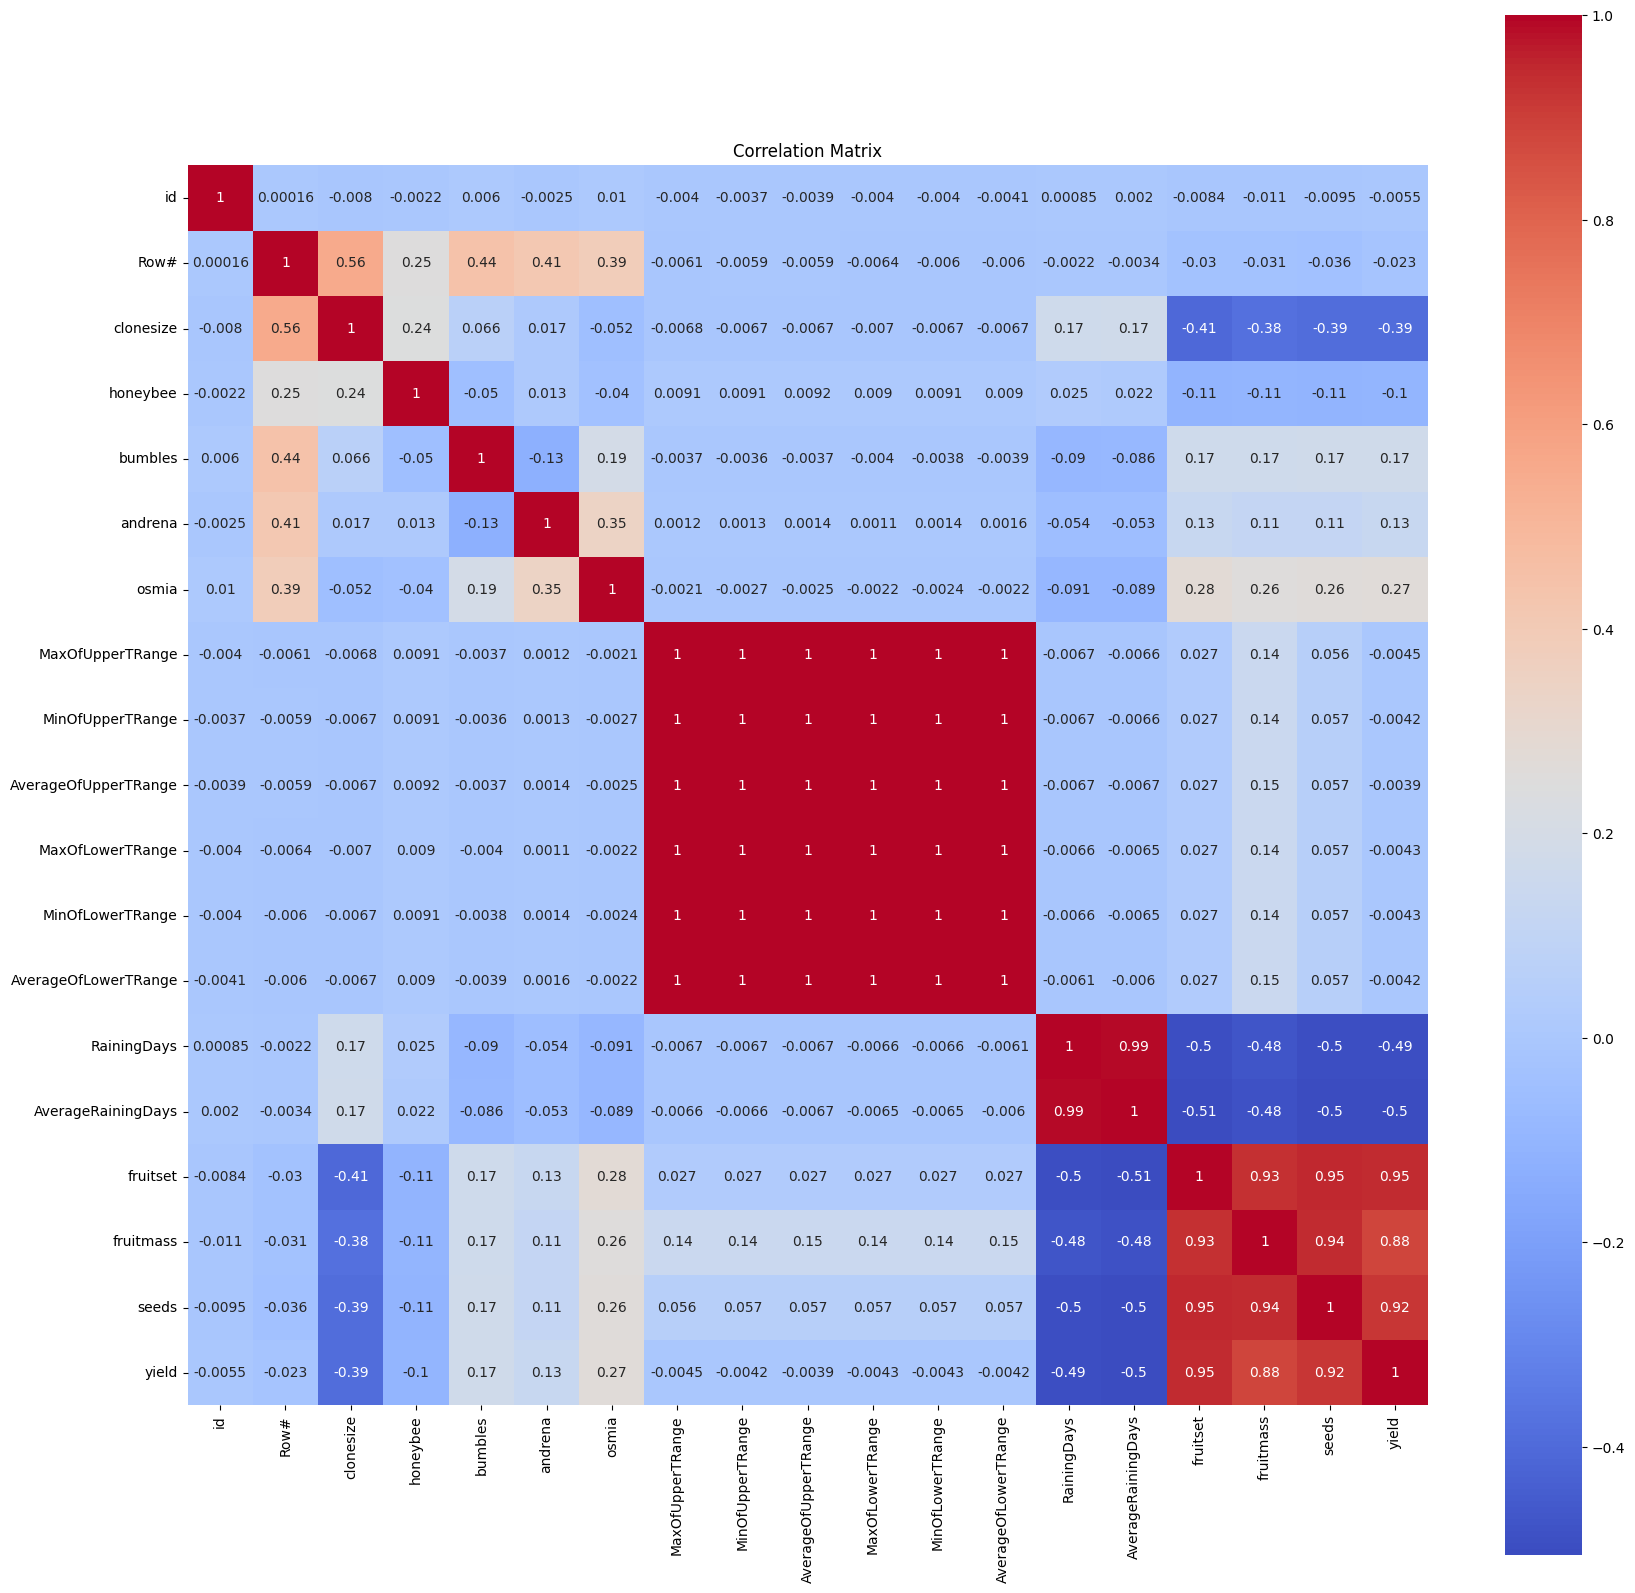

Features removed due to high correlation: ['MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'AverageRainingDays', 'fruitmass', 'seeds', 'yield']


In [3]:
# Finding Correlation
corr = trainData.corr(method = 'pearson')
# print(round(corr, 4))

# # Plot Graph between Correlation
# plt.matshow(corr)
# plt.show()

# Highly Correlated Features
# Set the threshold for high correlation
threshold = 0.8
# Create a list of highly correlated features
# Select upper triangle of correlation matrix
upperTriangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find features with correlation greater than threshold
high_corr_features = [column for column in upperTriangle.columns if any(upperTriangle[column].abs() > threshold)]

# Drop the highly correlated features from the Dataset
df_reduced = trainData.drop(high_corr_features, axis=1)

# Visualize the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

print(f"Features removed due to high correlation: {high_corr_features}")


### **Model: Ensemble Model - Voting**

In [ ]:
# Define features to include (inverse of what was excluded before)
features_to_use = [
    'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 
    'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 
    'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 
    'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds'
]

# Separate features (X) and target (y) in the training set
xTrain = trainData[features_to_use]
yTrain = trainData['yield']

# Prepare the test data
xTest = testData[features_to_use]

# Split the training set into train and validation sets for evaluation
xTrainSplit, xValSplit, yTrainSplit, yValSplit = train_test_split(xTrain, yTrain, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
xTrainSplit_scaled = scaler.fit_transform(xTrainSplit)
xValSplit_scaled = scaler.transform(xValSplit)
xTest_scaled = scaler.transform(xTest)

# Initialize individual ensemble models with hyperparameters
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

# Create a Voting Regressor using Random Forest and Gradient Boosting
votingEnsemble = VotingRegressor([('rf', rf_model), ('gb', gb_model)])

# Perform feature selection
selector = SelectFromModel(estimator=rf_model, threshold='median')
xTrainSplit_selected = selector.fit_transform(xTrainSplit_scaled, yTrainSplit)
xValSplit_selected = selector.transform(xValSplit_scaled)
xTest_selected = selector.transform(xTest_scaled)

# Train the ensemble model
votingEnsemble.fit(xTrainSplit_selected, yTrainSplit)

# Predict on the validation set
valPredict = votingEnsemble.predict(xValSplit_selected)

# Evaluate the performance
mse = mean_squared_error(yValSplit, valPredict)
r2 = r2_score(yValSplit, valPredict)
print(f'Mean Squared Error (Validation): {mse}')
print(f'R² Score (Validation): {r2}')

# Perform cross-validation
cv_scores = cross_val_score(votingEnsemble, xTrainSplit_selected, yTrainSplit, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
print(f'Cross-validated MSE: {cv_mse}')

# Predict on the test set using the trained ensemble model
testPredict = votingEnsemble.predict(xTest_selected)

# Save predictions for the test dataset
output = pd.DataFrame({
    'id': testData['id'],
    'yield': testPredict
})

# Save predictions to a CSV file
output.to_csv('blueberry_yield_ensemble_predictions.csv', index=False)

# Print selected features
selected_features = np.array(features_to_use)[selector.get_support()]
print("Selected features:")
print(selected_features)

Mean Squared Error (Validation): 159854.4109592247
R² Score (Validation): 0.9114703008671357


In [ ]:
# # Define Ridge, Lasso, Linear, Polynomial, and Bayesian Ridge models
# ridge_model = Ridge(alpha=1.0, random_state=43)
# lasso_model = Lasso(alpha=0.1, random_state=43)
# linear_model = LinearRegression()
# poly_model = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
# bayesian_model = BayesianRidge()

# # Initialize Voting Regressor with all models
# votingEnsemble = VotingRegressor([
#     ('rf', rf_model), 
#     ('gb', gb_model),
#     ('ridge', ridge_model),
#     ('lasso', lasso_model),
#     ('linear', linear_model),
#     ('poly', poly_model),
#     ('bayesian', bayesian_model)
# ])

# # Perform feature selection again
# xTrainSplit_selected = selector.fit_transform(xTrainSplit_scaled, yTrainSplit)
# xValSplit_selected = selector.transform(xValSplit_scaled)
# xTest_selected = selector.transform(xTest_scaled)

# # Train the ensemble model
# votingEnsemble.fit(xTrainSplit_selected, yTrainSplit)

# # Predict on the validation set
# valPredict = votingEnsemble.predict(xValSplit_selected)

# # Evaluate the performance
# mse = mean_squared_error(yValSplit, valPredict)
# r2 = r2_score(yValSplit, valPredict)
# print(f'Mean Squared Error (Validation): {mse}')
# print(f'R² Score (Validation): {r2}')

# # Perform cross-validation
# cv_scores = cross_val_score(votingEnsemble, xTrainSplit_selected, yTrainSplit, cv=5, scoring='neg_mean_squared_error')
# cv_mse = -cv_scores.mean()
# print(f'Cross-validated MSE: {cv_mse}')

# # Predict on the test set using the trained ensemble model
# testPredict = votingEnsemble.predict(xTest_selected)

# # Save predictions for the test dataset
# output = pd.DataFrame({
#     'id': testData['id'],
#     'yield': testPredict
# })

# # Save predictions to a CSV file
# output.to_csv('YieldPrediction.csv', index=False)

# # Print selected features
# selected_features = np.array(features_to_use)[selector.get_support()]
# print("Selected features:")
# print(selected_features)


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_regression
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
# from sklearn.linear_model import Ridge, Lasso, LinearRegression, BayesianRidge, ElasticNet, HuberRegressor
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# # Separate features and target
# X = trainData.drop(['id', 'yield'], axis=1)
# y = trainData['yield']

# # Print the number of features
# print(f"Number of features: {X.shape[1]}")

# # Split the data
# xTrain, xVal, yTrain, yVal = train_test_split(X, y, test_size=0.2, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# xTrainSplit_scaled = scaler.fit_transform(xTrain)
# xValSplit_scaled = scaler.transform(xVal)
# xTest_scaled = scaler.transform(testData.drop(['id'], axis=1))

# # Feature selection (using all features)
# selector = SelectKBest(f_regression, k='all')

# # Define models
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
# ridge_model = Ridge(alpha=1.0, random_state=43)
# lasso_model = Lasso(alpha=0.1, random_state=43)
# linear_model = LinearRegression()
# poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
# bayesian_model = BayesianRidge()
# elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=43)
# huber = HuberRegressor()
# svr = SVR(kernel='rbf')

# # Initialize Voting Regressor with all models
# votingEnsemble = VotingRegressor([
#     ('rf', rf_model), 
#     ('gb', gb_model),
#     ('ridge', ridge_model),
#     ('lasso', lasso_model),
#     ('linear', linear_model),
#     ('poly', poly_model),
#     ('bayesian', bayesian_model),
#     ('elastic_net', elastic_net),
#     ('huber', huber),
#     ('svr', svr)
# ])

# # Perform feature selection
# xTrainSplit_selected = selector.fit_transform(xTrainSplit_scaled, yTrain)
# xValSplit_selected = selector.transform(xValSplit_scaled)
# xTest_selected = selector.transform(xTest_scaled)

# # Train the ensemble model
# votingEnsemble.fit(xTrainSplit_selected, yTrain)

# # Predict on the validation set
# valPredict = votingEnsemble.predict(xValSplit_selected)

# # Evaluate the performance
# mse = mean_squared_error(yVal, valPredict)
# r2 = r2_score(yVal, valPredict)
# mae = mean_absolute_error(yVal, valPredict)
# print(f'Mean Squared Error (Validation): {mse}')
# print(f'R² Score (Validation): {r2}')
# print(f'Mean Absolute Error (Validation): {mae}')

# # Perform cross-validation
# cv_scores = cross_val_score(votingEnsemble, xTrainSplit_selected, yTrain, cv=5, scoring='neg_mean_squared_error')
# cv_r2 = cross_val_score(votingEnsemble, xTrainSplit_selected, yTrain, cv=5, scoring='r2')
# cv_mae = cross_val_score(votingEnsemble, xTrainSplit_selected, yTrain, cv=5, scoring='neg_mean_absolute_error')
# print(f'Cross-validation Mean Squared Error: {np.mean(cv_scores)}')
# print(f'Cross-validation R² Score: {np.mean(cv_r2)}')
# print(f'Cross-validation Mean Absolute Error: {np.mean(cv_mae)}')

In [ ]:
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# def xgboost_regression(X, y, testData=None, idTest=None, n_estimators=200, learning_rate=0.1, max_depth=5, test_size=0.2, random_state=42):        
#     # Split the dataset into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
#     # Scale the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Initialize XGBoost regressor
#     xgb_model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    
#     # Fit the XGBoost model
#     xgb_model.fit(X_train_scaled, y_train)
    
#     # Make predictions
#     y_pred = xgb_model.predict(X_test_scaled)
    
#     # Calculate metrics
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
    
#     print(f"\nXGBoost Regression Results:")
#     print(f'Mean Squared Error (MSE): {mse}')
#     print(f'R² Score: {r2}')
#     print(f'Mean Absolute Error (MAE): {mae}')
    
#     # Make predictions on testData (assuming testData is preprocessed similarly)
#     if testData is not None:
#         X_testData_scaled = scaler.transform(testData)
#         testPredictions = xgb_model.predict(X_testData_scaled)
        
#         # Save predictions to a CSV file
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'test_predictions_xgboost.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")

# # Example usage
# X = trainData[selectedFeature_1]  # Replace with your selected features
# y = trainData.iloc[:, -1]         # Replace with your target variable

# # Assuming testData is your test dataset
# xgboost_regression(X, y, testData=testData[selectedFeature_1], idTest=testData['id'], n_estimators=200, learning_rate=0.1, max_depth=5, test_size=0.2, random_state=42)


In [ ]:
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# def lightgbm_regression(X, y, testData=None, idTest=None, n_estimators=200, learning_rate=0.1, max_depth=5, test_size=0.2, random_state=42):        
#     # Split the dataset into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
#     # Scale the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Initialize LightGBM regressor
#     lgbm_model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    
#     # Fit the LightGBM model
#     lgbm_model.fit(X_train_scaled, y_train)
    
#     # Make predictions
#     y_pred = lgbm_model.predict(X_test_scaled)
    
#     # Calculate metrics
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
    
#     print(f"\nLightGBM Regression Results:")
#     print(f'Mean Squared Error (MSE): {mse}')
#     print(f'R² Score: {r2}')
#     print(f'Mean Absolute Error (MAE): {mae}')
    
#     # Make predictions on testData (assuming testData is preprocessed similarly)
#     if testData is not None:
#         X_testData_scaled = scaler.transform(testData)
#         testPredictions = lgbm_model.predict(X_testData_scaled)
        
#         # Save predictions to a CSV file
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'test_predictions_lightgbm.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")

# # Example usage
# X = trainData[selectedFeature_1]  # Replace with your selected features
# y = trainData.iloc[:, -1]         # Replace with your target variable

# # Assuming testData is your test dataset
# lightgbm_regression(X, y, testData=testData[selectedFeature_1], idTest=testData['id'], n_estimators=200, learning_rate=0.1, max_depth=5, test_size=0.2, random_state=42)


In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# def gradient_boosting_regression(X, y, testData=None, idTest=None, n_estimators=300, learning_rate=0.08, max_depth=6, test_size=0.2, random_state=42):        
#     # Split the dataset into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
#     # Scale the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Initialize Gradient Boosting Regressor
#     gb_model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    
#     # Fit the Gradient Boosting model
#     gb_model.fit(X_train_scaled, y_train)
    
#     # Make predictions
#     y_pred = gb_model.predict(X_test_scaled)
    
#     # Calculate metrics
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
    
#     print(f"\nGradient Boosting Regression Results:")
#     print(f'Mean Squared Error (MSE): {mse}')
#     print(f'R² Score: {r2}')
#     print(f'Mean Absolute Error (MAE): {mae}')
    
#     # Make predictions on testData (assuming testData is preprocessed similarly)
#     if testData is not None:
#         X_testData_scaled = scaler.transform(testData)
#         testPredictions = gb_model.predict(X_testData_scaled)
        
#         # Save predictions to a CSV file
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'test_predictions_gradient_boost.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")

# # Example usage
# X = trainData[selectedFeature_1]  # Replace with your selected features
# y = trainData.iloc[:, -1]         # Replace with your target variable

# # Assuming testData is your test dataset
# gradient_boosting_regression(X, y, testData=testData[selectedFeature_1], idTest=testData['id'], n_estimators=200, learning_rate=0.1, max_depth=5, test_size=0.2, random_state=42)


In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# import pandas as pd
# import numpy as np

# def select_best_features_using_importance(X, y, n_estimators=200, max_depth=5, random_state=42):
#     # Split the dataset into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
#     # Scale the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Initialize RandomForest or GradientBoosting to calculate feature importance
#     rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    
#     # Fit the model
#     rf_model.fit(X_train_scaled, y_train)
    
#     # Get feature importance
#     feature_importances = rf_model.feature_importances_
    
#     # Create a DataFrame with features and their importance
#     feature_importance_df = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': feature_importances
#     }).sort_values(by='Importance', ascending=False)
    
#     # Print the features sorted by importance
#     print("Features sorted by importance:")
#     print(feature_importance_df)

# # Example usage
# X = trainData[features_to_use]  # Replace with your selected features
# y = trainData['yield']          # Replace with your target variable

# select_best_features_using_importance(X, y)


In [ ]:
# from sklearn.feature_selection import SelectKBest, f_regression
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# import pandas as pd

# def select_best_features_using_selectkbest(X, y, k=5):
#     # Split the dataset into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     # Scale the features
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Apply SelectKBest to pick the top k features
#     selector = SelectKBest(score_func=f_regression, k=k)
#     selector.fit(X_train_scaled, y_train)
    
#     # Get the scores for each feature
#     feature_scores = selector.scores_
    
#     # Create a DataFrame with features and their scores
#     feature_scores_df = pd.DataFrame({
#         'Feature': X.columns,
#         'Score': feature_scores
#     }).sort_values(by='Score', ascending=False)
    
#     # Print the top k features
#     print(f"Top {k} features selected by SelectKBest:")
#     print(feature_scores_df.head(k))

# # Example usage
# X = trainData[features_to_use]  # Replace with your selected features
# y = trainData['yield']          # Replace with your target variable

# select_best_features_using_selectkbest(X, y, k=5)


In [ ]:
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# # Step 1: Select best features using Random Forest Feature Importance
# def select_best_features_using_importance(X, y, n_estimators=300, max_depth=5, random_state=42):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Fit RandomForest to find feature importance
#     rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
#     rf_model.fit(X_train_scaled, y_train)
    
#     # Get feature importance
#     feature_importances = rf_model.feature_importances_
    
#     # Sort features by importance
#     feature_importance_df = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': feature_importances
#     }).sort_values(by='Importance', ascending=False)
    
#     print("Features sorted by importance:")
#     print(feature_importance_df)
    
#     # Select top features (you can decide how many to select)
#     selected_features = feature_importance_df['Feature'].head(5)  # Selecting top 5 features
#     return selected_features

# # Step 2: Train a model using selected features
# def train_model_with_selected_features(X, y, selected_features, testData=None, idTest=None, model_type='gradient_boosting'):
#     X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Select model type
#     if model_type == 'gradient_boosting':
#         model = GradientBoostingRegressor(n_estimators=120, learning_rate=0.1, max_depth=4, random_state=42)
#     else:
#         raise ValueError("Unsupported model type")
    
#     # Fit the model
#     model.fit(X_train_scaled, y_train)
    
#     # Make predictions and evaluate
#     y_pred = model.predict(X_test_scaled)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
    
#     print(f"\nModel Results with Selected Features:")
#     print(f'Mean Squared Error (MSE): {mse}')
#     print(f'R² Score: {r2}')
#     print(f'Mean Absolute Error (MAE): {mae}')
    
#     # Predict on testData (optional)
#     if testData is not None:
#         X_testData_scaled = scaler.transform(testData[selected_features])
#         testPredictions = model.predict(X_testData_scaled)
        
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'test_predictions_selected_features.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")

# # Example usage
# X = trainData[features_to_use]  # All features initially
# y = trainData['yield']

# # Step 1: Select best features using feature importance
# selected_features = select_best_features_using_importance(X, y)

# # Step 2: Train a model with those selected features
# train_model_with_selected_features(X, y, selected_features, testData=testData, idTest=testData['id'])


In [ ]:
# from sklearn.feature_selection import SelectKBest, f_regression
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# # Step 1: Select best features using SelectKBest
# def select_best_features_using_selectkbest(X, y, k=5):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Apply SelectKBest to select top k features
#     selector = SelectKBest(score_func=f_regression, k=k)
#     selector.fit(X_train_scaled, y_train)
    
#     # Get selected features
#     selected_features = X.columns[selector.get_support()]
#     print(f"Selected features: {selected_features}")
    
#     return selected_features

# # Step 2: Train a model using selected features
# def train_model_with_selected_features(X, y, selected_features, testData=None, idTest=None, model_type='gradient_boosting'):
#     X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Select model type
#     if model_type == 'gradient_boosting':
#         model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
#     else:
#         raise ValueError("Unsupported model type")
    
#     # Fit the model
#     model.fit(X_train_scaled, y_train)
    
#     # Make predictions and evaluate
#     y_pred = model.predict(X_test_scaled)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
    
#     print(f"\nModel Results with Selected Features:")
#     print(f'Mean Squared Error (MSE): {mse}')
#     print(f'R² Score: {r2}')
#     print(f'Mean Absolute Error (MAE): {mae}')
    
#     # Predict on testData (optional)
#     if testData is not None:
#         X_testData_scaled = scaler.transform(testData[selected_features])
#         testPredictions = model.predict(X_testData_scaled)
        
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'test_predictions_selected_features.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")

# # Example usage
# X = trainData[features_to_use]  # All features initially
# y = trainData['yield']

# # Step 1: Select best features using SelectKBest
# selected_features = select_best_features_using_selectkbest(X, y, k=5)

# # Step 2: Train a model with those selected features
# train_model_with_selected_features(X, y, selected_features, testData=testData, idTest=testData['id'])


In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# import numpy as np
# # Step 1: Select best features using Random Forest Feature Importance (this part remains the same)
# def select_best_features_using_importance(X, y, n_estimators=550, max_depth=6, random_state=42):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Fit RandomForest to find feature importance
#     rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
#     rf_model.fit(X_train_scaled, y_train)
    
#     # Get feature importance
#     feature_importances = rf_model.feature_importances_
    
#     # Sort features by importance
#     feature_importance_df = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': feature_importances
#     }).sort_values(by='Importance', ascending=False)
    
#     print("Features sorted by importance:")
#     print(feature_importance_df)
    
#     # Select top features (you can decide how many to select)
#     selected_features = feature_importance_df['Feature'].head(5)  # Selecting top 5 features
#     return selected_features
# # Step 2: Train a model using selected features with Cross-Validation
# def train_model_with_selected_features_cv(X, y, selected_features, testData=None, idTest=None, model_type='gradient_boosting'):
#     X_selected = X[selected_features]
    
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_selected)
#     # Select model type
#     if model_type == 'gradient_boosting':
#         model = GradientBoostingRegressor(n_estimators=140, learning_rate=0.08, max_depth=5, random_state=42)
#     else:
#         raise ValueError("Unsupported model type")
#     # Perform 5-Fold Cross-Validation
#     cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
#     # Since the scoring returns negative MAE, we'll negate it to show positive values
#     print(f"\nCross-validated MAE (5-Fold): {np.mean(-cv_scores):.4f}")
    
#     # Fit the model on the entire dataset
#     model.fit(X_scaled, y)
    
#     # Predict on testData (optional)
#     if testData is not None:
#         X_test_scaled = scaler.transform(testData[selected_features])
#         testPredictions = model.predict(X_test_scaled)
        
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'submission.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")
# # Example usage
# X = trainData[features_to_use]  # All features initially
# y = trainData['yield']
# # Step 1: Select best features using feature importance
# selected_features = select_best_features_using_importance(X, y)
# # Step 2: Train a model with cross-validation using those selected features
# train_model_with_selected_features_cv(X, y, selected_features, testData=testData, idTest=testData['id'])

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# import numpy as np
# # Step 1: Select best features using Random Forest Feature Importance (this part remains the same)
# def select_best_features_using_importance(X, y, n_estimators=650, max_depth=7, random_state=42):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Fit RandomForest to find feature importance
#     rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
#     rf_model.fit(X_train_scaled, y_train)
    
#     # Get feature importance
#     feature_importances = rf_model.feature_importances_
    
#     # Sort features by importance
#     feature_importance_df = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': feature_importances
#     }).sort_values(by='Importance', ascending=False)
    
#     print("Features sorted by importance:")
#     print(feature_importance_df)
    
#     # Select top features (you can decide how many to select)
#     selected_features = feature_importance_df['Feature'].head(5)  # Selecting top 5 features
#     return selected_features
# # Step 2: Train a model using selected features with Cross-Validation
# def train_model_with_selected_features_cv(X, y, selected_features, testData=None, idTest=None, model_type='gradient_boosting'):
#     X_selected = X[selected_features]
    
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_selected)
#     # Select model type
#     if model_type == 'gradient_boosting':
#         model = GradientBoostingRegressor(n_estimators=140, learning_rate=0.08, max_depth=5, random_state=42)
#     else:
#         raise ValueError("Unsupported model type")
#     # Perform 5-Fold Cross-Validation
#     cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
#     # Since the scoring returns negative MAE, we'll negate it to show positive values
#     print(f"\nCross-validated MAE (5-Fold): {np.mean(-cv_scores):.4f}")
    
#     # Fit the model on the entire dataset
#     model.fit(X_scaled, y)
    
#     # Predict on testData (optional)
#     if testData is not None:
#         X_test_scaled = scaler.transform(testData[selected_features])
#         testPredictions = model.predict(X_test_scaled)
        
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'submission.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")
# # Example usage
# X = trainData[features_to_use]  # All features initially
# y = trainData['yield']
# # Step 1: Select best features using feature importance
# selected_features = select_best_features_using_importance(X, y)
# # Step 2: Train a model with cross-validation using those selected features
# train_model_with_selected_features_cv(X, y, selected_features, testData=testData, idTest=testData['id'])

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# import numpy as np
# # Step 1: Select best features using Random Forest Feature Importance (this part remains the same)
# def select_best_features_using_importance(X, y, n_estimators=600, max_depth=5, random_state=42):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Fit RandomForest to find feature importance
#     rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
#     rf_model.fit(X_train_scaled, y_train)
    
#     # Get feature importance
#     feature_importances = rf_model.feature_importances_
    
#     # Sort features by importance
#     feature_importance_df = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': feature_importances
#     }).sort_values(by='Importance', ascending=False)
    
#     print("Features sorted by importance:")
#     print(feature_importance_df)
    
#     # Select top features (you can decide how many to select)
#     selected_features = feature_importance_df['Feature'].head(5)  # Selecting top 5 features
#     return selected_features
# # Step 2: Train a model using selected features with Cross-Validation
# def train_model_with_selected_features_cv(X, y, selected_features, testData=None, idTest=None, model_type='gradient_boosting'):
#     X_selected = X[selected_features]
    
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_selected)
#     # Select model type
#     if model_type == 'gradient_boosting':
#         model = GradientBoostingRegressor(n_estimators=120, learning_rate=0.08, max_depth=5, random_state=42)
#     else:
#         raise ValueError("Unsupported model type")
#     # Perform 5-Fold Cross-Validation
#     cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
#     # Since the scoring returns negative MAE, we'll negate it to show positive values
#     print(f"\nCross-validated MAE (5-Fold): {np.mean(-cv_scores):.4f}")
    
#     # Fit the model on the entire dataset
#     model.fit(X_scaled, y)
    
#     # Predict on testData (optional)
#     if testData is not None:
#         X_test_scaled = scaler.transform(testData[selected_features])
#         testPredictions = model.predict(X_test_scaled)
        
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'submission.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")
# # Example usage
# X = trainData[features_to_use]  # All features initially
# y = trainData['yield']
# # Step 1: Select best features using feature importance
# selected_features = select_best_features_using_importance(X, y)
# # Step 2: Train a model with cross-validation using those selected features
# train_model_with_selected_features_cv(X, y, selected_features, testData=testData, idTest=testData['id'])

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# import numpy as np
# # Step 1: Select best features using Random Forest Feature Importance (this part remains the same)
# def select_best_features_using_importance(X, y, n_estimators=400, max_depth=7, random_state=42):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     # Fit RandomForest to find feature importance
#     rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
#     rf_model.fit(X_train_scaled, y_train)
    
#     # Get feature importance
#     feature_importances = rf_model.feature_importances_
    
#     # Sort features by importance
#     feature_importance_df = pd.DataFrame({
#         'Feature': X.columns,
#         'Importance': feature_importances
#     }).sort_values(by='Importance', ascending=False)
    
#     print("Features sorted by importance:")
#     print(feature_importance_df)
    
#     # Select top features (you can decide how many to select)
#     selected_features = feature_importance_df['Feature'].head(5)  # Selecting top 5 features
#     return selected_features
# # Step 2: Train a model using selected features with Cross-Validation
# def train_model_with_selected_features_cv(X, y, selected_features, testData=None, idTest=None, model_type='gradient_boosting'):
#     X_selected = X[selected_features]
    
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_selected)
#     # Select model type
#     if model_type == 'gradient_boosting':
#         model = GradientBoostingRegressor(n_estimators=120, learning_rate=0.06, max_depth=6, random_state=42)
#     else:
#         raise ValueError("Unsupported model type")
#     # Perform 5-Fold Cross-Validation
#     cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
#     # Since the scoring returns negative MAE, we'll negate it to show positive values
#     print(f"\nCross-validated MAE (5-Fold): {np.mean(-cv_scores):.4f}")
    
#     # Fit the model on the entire dataset
#     model.fit(X_scaled, y)
    
#     # Predict on testData (optional)
#     if testData is not None:
#         X_test_scaled = scaler.transform(testData[selected_features])
#         testPredictions = model.predict(X_test_scaled)
        
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'submission.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")
# # Example usage
# X = trainData[features_to_use]  # All features initially
# y = trainData['yield']
# # Step 1: Select best features using feature importance
# selected_features = select_best_features_using_importance(X, y)
# # Step 2: Train a model with cross-validation using those selected features
# train_model_with_selected_features_cv(X, y, selected_features, testData=testData, idTest=testData['id'])

In [ ]:
# from sklearn.linear_model import Lasso
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import pandas as pd

# # Step 1: Select best features using Lasso (L1 Regularization)
# def select_best_features_lasso(X, y, alpha=0.03):
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
    
#     # Apply Lasso to select important features
#     lasso = Lasso(alpha=alpha)
#     lasso.fit(X_scaled, y)
    
#     # Select non-zero coefficient features
#     selected_features = X.columns[lasso.coef_ != 0]
#     print("Selected features by Lasso:")
#     print(selected_features)
#     return selected_features

# # Step 2: Train a model using selected features with Cross-Validation
# def train_model_with_selected_features_cv(X, y, selected_features, testData=None, idTest=None, model_type='gradient_boosting'):
#     X_selected = X[selected_features]
    
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_selected)

#     # Select model type
#     if model_type == 'gradient_boosting':
#         model = GradientBoostingRegressor(n_estimators=120, learning_rate=0.06, max_depth=4, random_state=42)
#     else:
#         raise ValueError("Unsupported model type")

#     # Perform 5-Fold Cross-Validation
#     cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')

#     print(f"\nCross-validated MAE (5-Fold): {np.mean(-cv_scores):.4f}")
    
#     # Fit the model on the entire dataset
#     model.fit(X_scaled, y)
    
#     # Predict on testData (optional)
#     if testData is not None:
#         X_test_scaled = scaler.transform(testData[selected_features])
#         testPredictions = model.predict(X_test_scaled)
        
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'submission.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")

# # Example usage
# X = trainData[features_to_use]  # All features initially
# y = trainData['yield']

# # Step 1: Select best features using Lasso
# selected_features = select_best_features_lasso(X, y)

# # Step 2: Train a model with cross-validation using those selected features
# train_model_with_selected_features_cv(X, y, selected_features, testData=testData, idTest=testData['id'])


In [ ]:
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import pandas as pd

# # Step 1: Select best features using Recursive Feature Elimination (RFE)
# def select_best_features_rfe(X, y, n_features_to_select=7):
#     model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.06, max_depth=6, random_state=42)
#     rfe = RFE(model, n_features_to_select=n_features_to_select)
#     rfe.fit(X, y)
    
#     # Get the selected features
#     selected_features = X.columns[rfe.support_]
#     print("Selected features by RFE:")
#     print(selected_features)
#     return selected_features

# # Step 2: Train a model using selected features with Cross-Validation
# def train_model_with_selected_features_cv(X, y, selected_features, testData=None, idTest=None, model_type='gradient_boosting'):
#     X_selected = X[selected_features]
    
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X_selected)
    
#     # Select model type
#     if model_type == 'gradient_boosting':
#         model = GradientBoostingRegressor(n_estimators=120, learning_rate=0.06, max_depth=4, random_state=42)
#     else:
#         raise ValueError("Unsupported model type")
    
#     # Perform 5-Fold Cross-Validation
#     cv_scores = cross_val_score(model, X_scaled, y, cv=10, scoring='neg_mean_absolute_error')

#     print(f"\nCross-validated MAE (5-Fold): {np.mean(-cv_scores):.4f}")
    
#     # Fit the model on the entire dataset
#     model.fit(X_scaled, y)
    
#     # Predict on testData (optional)
#     if testData is not None:
#         X_test_scaled = scaler.transform(testData[selected_features])
#         testPredictions = model.predict(X_test_scaled)
        
#         output = pd.DataFrame({
#             'id': idTest,
#             'yield': testPredictions
#         })
        
#         output_file = 'submission.csv'
#         output.to_csv(output_file, index=False)
#         print(f"Predictions saved to {output_file}")

# # Example usage
# X = trainData[features_to_use]  # All features initially
# y = trainData['yield']

# # Step 1: Select best features using RFE
# selected_features = select_best_features_rfe(X, y)

# # Step 2: Train a model with cross-validation using those selected features
# train_model_with_selected_features_cv(X, y, selected_features, testData=testData, idTest=testData['id'])


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor, TheilSenRegressor
from sklearn.feature_selection import RFE, SelectFromModel, mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import numpy as np
import pandas as pd

# Step 1: Feature Extraction / Selection Techniques
def feature_selection_method(method, X, y, n_features=5):
    if method == 'random_forest_importance':
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        rf.fit(X, y)
        importances = rf.feature_importances_
        selected_features = X.columns[np.argsort(importances)[::-1][:n_features]]
    elif method == 'rfe':
        model = GradientBoostingRegressor(n_estimators=120, learning_rate=0.09, max_depth=5, random_state=42)
        rfe = RFE(model, n_features_to_select=n_features)
        rfe.fit(X, y)
        selected_features = X.columns[rfe.support_]
    elif method == 'lasso':
        lasso = Lasso(alpha=0.01)
        lasso.fit(X, y)
        selected_features = X.columns[lasso.coef_ != 0]
    elif method == 'mutual_info':
        mi = mutual_info_regression(X, y)
        selected_features = X.columns[np.argsort(mi)[::-1][:n_features]]
    elif method == 'select_kbest':
        selector = SelectKBest(f_regression, k=n_features)
        selector.fit(X, y)
        selected_features = X.columns[selector.get_support()]
    else:
        raise ValueError(f"Unknown feature selection method: {method}")
    
    print(f"Selected features using {method}: {selected_features}")
    return selected_features

# Step 2: Train Model using Selected Regressor
def train_regressor(X, y, selected_features, regressor_type, testData=None, idTest=None):
    X_selected = X[selected_features]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    # Define different regression models
    regressors = {
        'linear_regression': LinearRegression(),
        'ridge': Ridge(alpha=1.0),
        'lasso': Lasso(alpha=0.01),
        'elastic_net': ElasticNet(alpha=0.01),
        'decision_tree': DecisionTreeRegressor(),
        'random_forest': RandomForestRegressor(n_estimators=200, random_state=42),
        'gradient_boosting': GradientBoostingRegressor(n_estimators=120, learning_rate=0.09, max_depth=5, random_state=42),
        'adaboost': AdaBoostRegressor(n_estimators=120, random_state=42),
        'xgboost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.09, max_depth=5, random_state=42),
        'lightgbm': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.09, max_depth=5, random_state=42),
        'catboost': cb.CatBoostRegressor(n_estimators=100, learning_rate=0.09, max_depth=5, verbose=0),
        'svr': SVR(kernel='linear', C=1.0),
        'k_neighbors': KNeighborsRegressor(n_neighbors=5),
        'huber': HuberRegressor(),
        'theil_sen': TheilSenRegressor(),
    }
    
    if regressor_type not in regressors:
        raise ValueError(f"Unsupported regressor type: {regressor_type}")
    
    model = regressors[regressor_type]

    # Perform 5-Fold Cross-Validation
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    
    print(f"\nCross-validated RMSE for {regressor_type}: {np.sqrt(np.mean(-cv_scores)):.4f}")
    
    # Fit the model on the entire dataset
    model.fit(X_scaled, y)
    
    # Predict on testData (optional)
    if testData is not None:
        X_test_scaled = scaler.transform(testData[selected_features])
        testPredictions = model.predict(X_test_scaled)
        
        output = pd.DataFrame({
            'id': idTest,
            'yield': testPredictions
        })
        
        output_file = 'submission.csv'
        output.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")

# Example usage
X = trainData[features_to_use]  # All features initially
y = trainData['yield']

# Step 1: Select features using a specific method
selection_method = 'rfe'  # You can change this to 'random_forest_importance', 'lasso', 'mutual_info', etc.
selected_features = feature_selection_method(selection_method, X, y)

# Step 2: Train with different regression models
regressor = 'xgboost'  # Try 'linear_regression', 'ridge', 'random_forest', 'svr', etc.
train_regressor(X, y, selected_features, regressor, testData=testData, idTest=testData['id'])
